# 1. Librairies importation

In [1]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import copy
import pickle

# 2. Models

In [19]:
class MNIST_MLP(nn.Module):
    def __init__(self, num_inp, num_hid, num_out):
        super(MNIST_MLP, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))
    
    def forward(self, x):
        """Compute a prediction."""
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x

# 3. Functions

In [20]:
def validation(model, data_loader, device):
    model = copy.deepcopy(model)
    model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(data_loader):
        #print(i)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [25]:
def training(model, train_dataset, test_dataset, optimizer, batch_sizes, target_acc, epoch, loss_fn, device):
    model.train()
    steps = []
    # Train the model for different batch sizes
    for batch_size in batch_sizes:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)
        # Re initialize the model
        model.initialize()
        step = 0
        # Value to know if we must change the batch size
        new_batch = False
        for i in range(epoch):
            if new_batch:
                break
            loss_epoch = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                #print(batch_idx)
                optimizer.zero_grad()

                data = data.to(device)
                target = target.to(device)
                output = model(data)

                # Check to know if at step k, the accuracy is greater than the target accuracy
                accuracy = validation(model, test_loader, device)
                #print(accuracy)
                if accuracy >= target_acc:
                    print('Validation accuracy = {:.6f} reached at step {}'.format(accuracy, step))
                    steps.append(step)
                    new_batch = True
                    break

                loss = loss_fn(output, target)

                loss_epoch += loss.item()

                loss.backward()
                optimizer.step()

                step += 1
            
            loss_epoch /= len(train_loader)

            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                i, loss_epoch))

    return steps


# 4. Experimentation

## MNIST

In [35]:
#batch_sizes = [1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9]
batch_sizes = [2**5, 2**6, 2**7, 2**8, 2**9]
target_acc = 0.9
epoch = 40
loss_fn = nn.CrossEntropyLoss()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

# Keep only n samples for validation
n = 256
test_dataset, _ = torch.utils.data.random_split(test_dataset, [n, len(test_dataset) - n])

# Initialize the model
model = MNIST_MLP(28*28, 128, 10).to(DEVICE)
model.initialize()

# Experimentation with non hyper-optimized SGD
# No momentum to focus on the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Experiments several times to get robust results
iter = 10
mean_steps = [0] * len(batch_sizes)
for i in range(iter):
    steps = training(model, train_dataset, test_dataset, optimizer, batch_sizes, target_acc, epoch, loss_fn, DEVICE)
    mean_steps = [x + y for x, y in zip(mean_steps, steps)]
mean_steps = [x / iter for x in mean_steps]


Train Epoch: 0 	Loss: 1.407031
Train Epoch: 1 	Loss: 1.123443
Train Epoch: 2 	Loss: 1.064043
Validation accuracy = 0.902344 reached at step 6052
Train Epoch: 3 	Loss: 0.238702
Train Epoch: 0 	Loss: 1.568031
Train Epoch: 1 	Loss: 1.231590
Train Epoch: 2 	Loss: 1.146510
Train Epoch: 3 	Loss: 1.100990
Train Epoch: 4 	Loss: 1.072651
Train Epoch: 5 	Loss: 1.053330
Train Epoch: 6 	Loss: 1.039047
Train Epoch: 7 	Loss: 1.027795
Validation accuracy = 0.902344 reached at step 7547
Train Epoch: 8 	Loss: 0.047121
Train Epoch: 0 	Loss: 1.750638
Train Epoch: 1 	Loss: 1.363983
Train Epoch: 2 	Loss: 1.253322
Train Epoch: 3 	Loss: 1.193578
Train Epoch: 4 	Loss: 1.154464
Train Epoch: 5 	Loss: 1.126550
Train Epoch: 6 	Loss: 1.105714
Train Epoch: 7 	Loss: 1.089427
Train Epoch: 8 	Loss: 1.076283
Train Epoch: 9 	Loss: 1.065530
Train Epoch: 10 	Loss: 1.056469


KeyboardInterrupt: 

In [33]:
print(steps)

[842, 829, 806, 889, 1152]


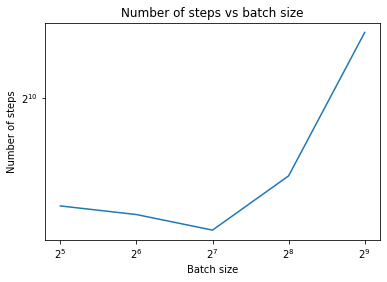

In [34]:
# Plot of the steps vs batch size
plt.plot(batch_sizes, steps)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xlabel('Batch size')
plt.ylabel('Number of steps')
plt.title('Number of steps vs batch size')
plt.show()

In [89]:
# Save the list to a file
with open('my_list.pkl', 'wb') as f:
    pickle.dump(my_list, f)

# Load the list from the file
with open('my_list.pkl', 'rb') as f:
    my_list = pickle.load(f)

NameError: name 'my_list' is not defined